
# Exercise 1.2
## Classification of MNIST digits with a fully-connected neural network

In this exercise we will classify [MNIST digits](https://en.wikipedia.org/wiki/MNIST_database) using a fully-connected neural network

## Part 1: Using a Jupyter notebook on HPC
If you are reading this, you probably already managed to open the Jupyter notebook on HPC -- if not, try to do that before doing the exercise.
We start by importing the modules that we need

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
torch.cuda.is_available()

True

We check that we have a GPU available

In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

The code will run on GPU.


The MNIST dataset is a built-in dataset in PyTorch (it is a very common dataset to test algorithms on). 

We import it, and set our minibatch size

In [4]:
batch_size = 64
trainset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

100%|████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 46509067.57it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 4416175.49it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 20915036.31it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 10595399.76it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



First, we plot the images to get an idea of what data we're working with. MNIST images are $28\times28$ images of handwritten digits (0-9)

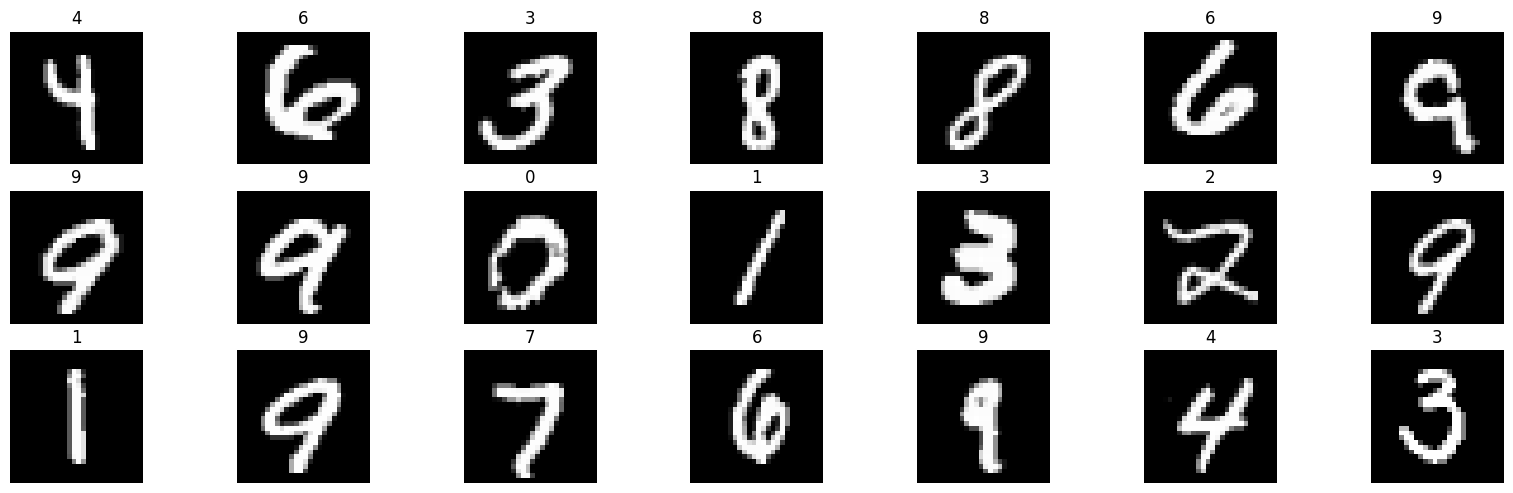

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy()[0], 'gray')
    plt.title(labels[i].item())
    plt.axis('off')

You should implement a fully-connected network to classify the digits. It should contain 1 hidden layer with 100 units. Don't forget the ReLU activation function after the hidden layer. 

In [6]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fully_connected1 = nn.Sequential(
            nn.Linear(28*28,100),
            nn.ReLU(),
            )
        
        self.fully_connected2 = nn.Sequential(
            nn.Linear(100,10),
            nn.Softmax(dim = 1)
            )
        
    def forward(self, x):
      #reshaping x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0),-1)
        x = self.fully_connected1(x)
        x = self.fully_connected2(x)
        return x

We instantiate a copy of our network and transfer it to the GPU if it's available

In [7]:
model = Network()
model.to(device)
#Initialize the optimer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

We train the network for five epochs

In [8]:
num_epochs = 5

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = F.nll_loss(torch.log(output), target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    test_correct = 0
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().item()
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 87.9%	 test: 92.5%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 93.3%	 test: 94.3%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 95.0%	 test: 95.6%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 96.1%	 test: 96.2%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 96.8%	 test: 96.6%


You should now have a model that has about 96% accuracy on the test set.
Try to get an even better accuracy. You can
* Change the number of hidden layers
* Change the number of units in the hidden layers
* Try changing the learning rate by factors of 10. What happens if it is too high or too low?
* Try using sigmoid instead of ReLU activation. What happens?

How large accuracy can you get?

Try showing the classification output (probabilities) from the model alongside the ground truth.

* Which are classified correctly/incorrectly? 
* If it's incorrect, what is the second most likely class?
* Do the misclassifications you see make sense? Why/why not?

In [25]:
predicted, test_correct

(tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]), 9664)

Text(0.5, 1.0, 'Prediction: 3, Label: 3')

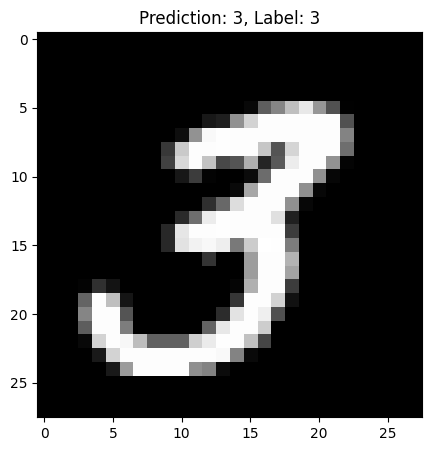

In [23]:
img = 2

model.eval()

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow(images[img].numpy()[0], 'gray')
ax.set_title(f'Prediction: {model(images[img].to(device).unsqueeze(0)).argmax(1).item()}, Label: {labels[img].item()}')

## Part 2: Running code in the terminal
Next, implement the classifier from this Jupyter notebook in a (reasonably clean) python script and train it from a terminal on HPC.